In [1]:
"""Implementing Neural networks for classification from scratch.
Steps involved are - 
1. Define the architecture - number of layers, number of units in each layer.
2. Define the cost function.
3. Initialise the weights.
4. Feed forward pass.
5. Backpropagation fo error.
6. Update by batch Gradient descent as well as stochastic gradient descent.
7. Test on some dataset.
8. Try to look at the activations to find out what the network is actually learning.
""";

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
def initialisation(nlayers,nunits):
    """Define the neural net architecture.
    Arguments - number of layers including input layer, list of units
    in each layer including the input layer in order."""
    
    arch={}
    for j in range(nlayers):
        arch[str(j)] = nunits[j]
        
    weights = {}
    for i in range(nlayers-1):
        weights['W'+str(i+1)] = np.sqrt(1/arch[str(i)])*np.random.randn(arch[str(i+1)],arch[str(i)])
        weights['b'+str(i+1)] = np.sqrt(1/arch[str(i)])*np.random.randn(arch[str(i+1)],1)

    return weights



In [25]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def relu(z):
    return z*(z>0)

def softmax(z):
    return np.exp(z)/np.sum(np.exp(z),axis=0)

In [26]:
def grad_sigm(z):
    return sigmoid(z)*(1-sigmoid(z))
def grad_relu(z):
    k = relu(z)
    k[k>0]=1
    return k

In [27]:
def feed_forward(data,weights,nlayers,activation='relu'):
    cache={}
    cache['a0'] = data
    for i in range(nlayers-1):
        cache['z'+str(i+1)] = np.matmul(weights['W'+str(i+1)],cache['a'+str(i)]) + weights['b'+str(i+1)]
        if i!=nlayers-2:
            if activation=='sigmoid':
                cache['a'+str(i+1)] = sigmoid(cache['z'+str(i+1)])
            elif activation == 'relu':
                cache['a'+str(i+1)] = relu(cache['z'+str(i+1)])
        else:
            # last layer activation is chosen to be sigmoid
            cache['a'+str(i+1)] = softmax(cache['z'+str(i+1)])
#             cache['a'+str(i+1)] = np.exp(cache['z'+str(i+1)])/np.sum(np.exp(cache['z'+str(i+1)]),axis=1)
    
    return cache

In [28]:
def cost(Y,out):
#     J = np.sum(-Y*np.log(out) - (1-Y)*np.log(1-out))
#     J = 0.5*(1/Y.shape[1])*np.sum((Y-out)**2) # mean square error
    J = np.sum(-Y*np.log(out))
    return J

In [29]:
def backprop(data,Y,cache,weights,nlayers,activation='relu'):
    grads={}
#     grads['da'+str(nlayers-1)] = (-Y/cache['a'+str(nlayers-1)]) + ((1-Y)/(1-cache['a'+str(nlayers-1)])) # logistic regression error
#     grads['da'+str(nlayers-1)] = cache['a'+str(nlayers-1)] - Y # Mean squared error
    for i in reversed(range(nlayers-1)):
        if i == nlayers-2:
#             grads['dz'+str(i+1)] = grads['da'+str(i+1)]*grad_sigm(cache['z'+str(i+1)]) # logistic or mse error
            grads['dz'+str(i+1)]=cache['a'+str(nlayers-1)] - Y # softmax error
        else:
            if activation=='sigmoid':
                grads['dz'+str(i+1)] = grads['da'+str(i+1)]*grad_sigm(cache['z'+str(i+1)])
            elif activation=='relu':
                grads['dz'+str(i+1)] = grads['da'+str(i+1)]*grad_relu(cache['z'+str(i+1)])
        grads['dW'+str(i+1)] = np.matmul(grads['dz'+str(i+1)],cache['a'+str(i)].T)                     
        grads['db'+str(i+1)] = np.sum(grads['dz'+str(i+1)],axis=1).reshape(grads['dz'+str(i+1)].shape[0],1)

        grads['da'+str(i)] = np.matmul(weights['W'+str(i+1)].T,grads['dz'+str(i+1)])
 
    return grads

In [30]:
def update(weights,grads,nlayers,alpha):
    for i in range(nlayers-1):
        weights['W'+str(i+1)] = weights['W'+str(i+1)] - alpha*grads['dW'+str(i+1)]
    return weights

In [31]:
def nn(X,Y_enc,activation,nunits,nlayers,num_iter,alpha):
    iter_cost=[]
    weights = initialisation(nlayers,nunits)
    for i in range(num_iter):
        cache = feed_forward(X,weights,nlayers,activation)
        iter_cost.append(cost(Y_enc,cache['a'+str(nlayers-1)]))
        grads = backprop(X,Y_enc,cache,weights,nlayers,activation)
        weights = update(weights,grads,nlayers,alpha)
    return iter_cost,weights

In [32]:
def fit_and_predict(xtrain,ytrain,xtest,ytest,nlayers,nunits,activation,num_iter=1000,alpha=0.001):
    iter_cost,weights = nn(xtrain,ytrain,activation,nunits,nlayers,num_iter,alpha)
    plt.plot(iter_cost)
    test_error   = 100*np.sum(abs(np.argmax(feed_forward(xtest,weights,nlayers,activation)['a'+str(nlayers-1)],axis=0) - np.argmax(ytest,axis=0)))/ytest.shape[1]
    train_error = 100*np.sum(abs(np.argmax(feed_forward(xtrain,weights,nlayers,activation)['a'+str(nlayers-1)],axis=0) - np.argmax(ytrain,axis=0)))/ytrain.shape[1]
    print('train accuracy = ', 100-train_error,' %')
    print('test accuracy = ', 100- test_error,' %')
    return 

# 1. IRIS dataset

In [33]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',header=None)

In [34]:
data.rename(columns = {0:'A',1:'B',2:'C',3:'D',4:'labels'},inplace=True)

In [35]:
Y = data['labels']
X = data[['A','B','C','D']]

In [36]:
from sklearn.model_selection import train_test_split
X,X_test,Y,Y_test = train_test_split(X,Y,test_size=0.2)

In [37]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
le = LabelEncoder()
Y_enc= le.fit_transform(Y)
Y_test = le.transform(Y_test)
ohe = OneHotEncoder()
Y_enc = ohe.fit_transform(Y_enc.reshape(-1,1)).toarray()
Y_test = ohe.transform(Y_test.reshape(-1,1)).toarray()

In [38]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = sc.transform(X_test)

In [39]:
X = X.T
X_test = X_test.T
Y_enc = Y_enc.T
Y_test=Y_test.T

train accuracy =  99.1666666667  %
test accuracy =  96.6666666667  %


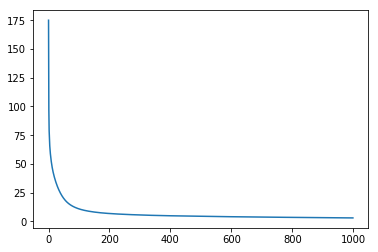

In [75]:
fit_and_predict(X,Y_enc,X_test,Y_test,nlayers=4,nunits=[4,30,30,3],activation='relu',num_iter=1000,alpha=0.001)

# 2. Applying on Breast cancer dataset from scikit learn

In [76]:
from sklearn.datasets import load_breast_cancer

In [77]:
data = load_breast_cancer()
y=data.target
X=data.data

In [78]:
x,x_test,y,y_test = train_test_split(X,y,test_size=0.2)

In [79]:
sc = StandardScaler()
x = sc.fit_transform(x)
x_test = sc.transform(x_test)

In [80]:
ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1,1)).toarray()
y_test = ohe.transform(y_test.reshape(-1,1)).toarray()
x = x.T
x_test = x_test.T
y = y.T
y_test=y_test.T

train accuracy =  99.7802197802  %
test accuracy =  98.2456140351  %


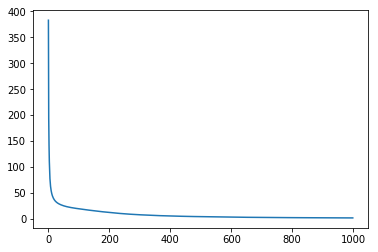

In [110]:
fit_and_predict(x,y,x_test,y_test,nlayers=3,nunits=[30,15,2],activation='relu',num_iter=1000,alpha=0.001)